<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Churn-Prediction" data-toc-modified-id="Churn-Prediction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Churn Prediction</a></span><ul class="toc-item"><li><span><a href="#Problem-Statement" data-toc-modified-id="Problem-Statement-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Problem Statement</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Basic-Data-Preparation" data-toc-modified-id="Basic-Data-Preparation-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Basic Data Preparation</a></span><ul class="toc-item"><li><span><a href="#Storing-variables-for-future-usage" data-toc-modified-id="Storing-variables-for-future-usage-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Storing variables for future usage</a></span></li></ul></li></ul></li></ul></div>

# Churn Prediction

## Problem Statement

There is a telecom company that offers phone and internet services. There is a problem: some of our customers are churning. We would like to build a model that can identify the customers that are likely to churn. We have collected a dataset about our customers: what type of services they use, how much they paid, and how long they stayed with us. We also know who canceled their contracts and stopped using our services (churned). 

In this notebook, we are going to do initial data preparation that will be used in subsequent notebooks.

## Imports

In [1]:
# usual imports 
import numpy as np
import pandas as pd

import math

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## Basic Data Preparation
We will begin with initial data preparation.

In [2]:
# Read the dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**Basic information**

- We have 7043 rows and 21 columns
- Out of 21 columns, 19 are feature columns

In [3]:
df.shape

(7043, 21)

**Column names transformation**

We are going to keep column names uniform for the whole dataset. We will do lower casing and then replace spaces with  underscore.

**Categorical string columns values transformation**

We are going to change the values of features that are categorical in nature. Fom the data snapshot above, we can see all the columns that are of *object* data type are categorical.

**Predicted variable transformation**

We are going to change predicted variable to integer with churned customers set as 1 and 0 otherwise.

In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

df.churn = (df.churn == 'yes').astype(int)

**Test dataset creation**

We are going to create training and test dataset and we will keep test dataset aside. 

We are also going to create a copy of training dataset which we will use for exploratory data analysis.

In [6]:
from sklearn.model_selection import train_test_split

df_train_full,  df_test = train_test_split(df, test_size= 0.2, random_state = 1)

df_train_full_explore = df_train_full.copy(deep = True)

df_train_full = df_train_full.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train_full = df_train_full.churn.values
y_test = df_test.churn.values

df_train,  df_val = train_test_split(df_train_full, test_size= 0.33, random_state = 11)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values

**Target variable distribution**

Approximately 26% of customers have churned and rest have not. It can be said that data has mild imbalance ([reference](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data)).

In [7]:
df_train_full_explore.churn.value_counts()

0    4113
1    1521
Name: churn, dtype: int64

In [8]:
df_train_full_explore.churn.value_counts(normalize=True)

0    0.730032
1    0.269968
Name: churn, dtype: float64

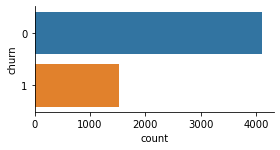

In [9]:
ax = sns.catplot(y="churn", kind="count", data=df_train_full_explore, height=2, aspect=2, orient='v')

**Analyzing column data types and handling missing values**

We will analyze the data types of dataset and convert columns to appropriate data type if required. Below we observe that *TotalCharges* column should be numerical data type like float64 or int64 . At the same time,  we also observe that there are missing values in *TotalCharges* column. These missing values are strings with just single space values. We will handle them by imputing them to 0. Reason behind imputing them to 0 is that for all such customers, tenure is zero. It is safe to say that such customers never paid anything.

When we say missing values, we are going to take following into values into consideration:

- NaN
- Empty string
- Strings with just space in it.

Observations:
- There are 11 rows that have missing value in *TotalCharges* column.
- Other than *TotalCharges* column, no ther feature column has missing value. 

In [10]:
df_column_type_plus_number_of_null_values = pd.concat([df_train_full_explore.dtypes, df_train_full_explore.isnull().sum()], axis=1)
df_column_type_plus_number_of_null_values.columns = ['column_type', 'number_of_null_values']
df_column_type_plus_number_of_null_values

,column_type,number_of_null_values
customerid,object,0
gender,object,0
seniorcitizen,int64,0
partner,object,0
dependents,object,0
tenure,int64,0
phoneservice,object,0
multiplelines,object,0
internetservice,object,0
onlinesecurity,object,0


**Note**: There are no nan values in the dataframe.

In [11]:
empty_string_locations = np.where(df_train_full_explore.applymap(lambda x: x == ' '))
print(empty_string_locations)
total_charges = pd.to_numeric(df_train_full_explore.totalcharges, errors= 'coerce')
df_train_full_explore[total_charges.isnull()][['customerid', 'tenure' ,'totalcharges']]

(array([], dtype=int64), array([], dtype=int64))


,customerid,tenure,totalcharges
3826,3213-vvolg,0,_
936,5709-lvoeq,0,_
1082,4367-nuyao,0,_
5218,2923-arzlg,0,_
6754,2775-sefee,0,_
488,4472-lvygi,0,_
1340,1371-dwpaz,0,_
753,3115-czmzd,0,_


In [ ]:
df_train_full_explore.totalcharges = pd.to_numeric(df_train_full_explore.totalcharges, errors= 'coerce')
df_train_full_explore.totalcharges = df_train_full_explore.totalcharges.fillna(0)

df_train_full_explore.totalcharges = df_train_full_explore.totalcharges.fillna(0)
df_test.totalcharges = df_test.totalcharges
df_train
df_val


### Storing variables for future usage

In [ ]:
categorical_features = [
    'gender', 'seniorcitizen', 'partner', 'dependents',
    'phoneservice', 'multiplelines', 'internetservice',
    'onlinesecurity', 'onlinebackup', 'deviceprotection',
    'techsupport', 'streamingtv', 'streamingmovies', 
    'contract', 'paperlessbilling', 'paymentmethod'
]
numerical_features = ['tenure', 'monthlycharges', 'totalcharges']

In [ ]:
if 'churn' in list(df_train_full.columns):
    del df_train_full['churn'] 

if 'churn' in list(df_train.columns):
    del df_train['churn']

if 'churn' in list(df_train.columns):
    del df_val['churn']

if 'churn' in list(df_train.columns):
    del df_test['churn'] 

%store df_train_full_explore
%store df_train_full
%store df_train
%store df_test
%store df_val

%store y_train_full
%store y_train
%store y_val
%store y_test

%store categorical_features
%store numerical_features